# \[set-up\], imports
Reminder (if working on the notebook server): make sure your copy of `pint_pal` is up to date and you're working on a development branch, e.g. `psr/J1234+5678/jks`. See README for more details. If not working on the notebook server, you may need to update required software packages (`pint`, `enterprise`, `enterprise_extensions`) according to requirements in `setup.py`.

In [1]:
import os
import sys
import datetime


import pint_pal.par_checker as pc
import pint_pal.dmx_utils as du
import pint_pal.lite_utils as lu
import pint_pal.noise_utils as nu
import pint_pal.plot_utils as pu
from pint_pal.ftester import run_Ftests
from pint_pal.utils import resid_stats, pdf_writer, apply_cut_select
from pint_pal.utils import check_recentness_excision, check_recentness_noise
from pint_pal.timingconfiguration import TimingConfiguration
from astropy import log
from pint.fitter import ConvergenceFailure
import pint.fitter
from pint.utils import dmxparse
import os
import copy
from astropy.visualization import quantity_support
quantity_support()

# notebook gives interactive plots but not until the kernel is done
#%matplotlib notebook
# inline gives non-interactive plots right away
#%matplotlib inline
%matplotlib widget

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Default assumption is that notebook is being run by hand
autorun = False
run_Ftest = True  # Set to False if you don't need F-tests and want a faster notebook run!
check_excision = True
num_noise_iter = 2e5

if not autorun:
    run_noise_analysis = False
    use_existing_noise_dir = True
    use_toa_pickle = False
else:
    run_noise_analysis = True 
    use_existing_noise_dir = False
    use_toa_pickle = False

In [3]:
log.setLevel("INFO") # Set desired verbosity of log statements (DEBUG/INFO/WARNING/ERROR)
log_to_file = False

if pint.__version__ > '0.8.6':  # see https://github.com/nanograv/PINT/blob/master/CHANGELOG.md
    pint.logging.setup(level="WARNING", usecolors=True)

lu.git_config_info()

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



INFO: Your git config user.name is: Ben Schumont [pint_pal.lite_utils]
INFO: ...to change this, in a terminal: git config user.name "First Last" [pint_pal.lite_utils]
INFO: Your git config user.email is: benschumont@gmail.com [pint_pal.lite_utils]
INFO: ...to change this, in a terminal: git config user.email "first.last@nanograv.org" [pint_pal.lite_utils]


WARNING  (pint.fitter                   ): fit_toas() has not been run, so pre-fit and post-fit will be the same!


# develop/update \[prenoise\] timing solution

Load configuration (`.yaml`) file, get TOAs and timing model; if you're running from the root of the git distribution, simply edit the `.yaml` file name, otherwise include relevant paths to the `.yaml` file, and `.par`/`.tim` directories as kwargs (see commented example).

In [4]:
config = "J2145-0750-CLEANED.chime.nb.yaml"   # fill in actual path
par_directory = None   # default location
tim_directory = None   # default location

tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)


using_wideband = tc.get_toa_type() == 'WB'

# Use excise.tim file if it exists, else revert to raw TOAs & initial cuts
mo,to = tc.get_model_and_toas(excised=False,usepickle=use_toa_pickle)
#This means mo = timing model, to = TOAs

# Checks if TOAs is empty and gets them if it is
if not to: mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
tc.manual_cuts(to)

if log_to_file:
    lu.log_notebook_to_file(tc.get_source(), tc.get_toa_type())
    lu.log_warnings()

INFO: Par file created: 2024-02-13T17:48:03.996959 [pint_pal.timingconfiguration]
INFO: Frontend/backend pairs present in this data set: {'Rcvr_800_GASP', 'CHIME', 'Rcvr_800_GUPPI', 'Rcvr1_2_GASP', 'Rcvr1_2_GUPPI'} [pint_pal.timingconfiguration]
INFO: Rcvr_800_GASP files: 21 [pint_pal.timingconfiguration]
INFO: CHIME files: 238 [pint_pal.timingconfiguration]
INFO: Rcvr_800_GUPPI files: 126 [pint_pal.timingconfiguration]
INFO: Rcvr1_2_GASP files: 22 [pint_pal.timingconfiguration]
INFO: Rcvr1_2_GUPPI files: 128 [pint_pal.timingconfiguration]
INFO: Specified TOA excision keys: {'mjd-end', 'snr-cut'} [pint_pal.timingconfiguration]
INFO: Selecting 22342 TOAs out of 22342 (0 removed based on initial cuts, specified keys). [pint_pal.utils]
INFO: Specified TOA excision keys: set() [pint_pal.timingconfiguration]
INFO: Selecting 22342 TOAs out of 22342 (0 removed based on manual cuts, specified keys). [pint_pal.utils]
INFO: Specified TOA excision keys: set() [pint_pal.timingconfiguration]
INFO: 

In [5]:
# Computing pulse numbers ensures param changes in the model will not break phase connection
to.compute_pulse_numbers(mo)

In [6]:
chime_bin = 20.

In [7]:
%load_ext autoreload
%autoreload 2
import pint_pal.dmx_utils as du

#to = du.setup_dmx(mo, to, frequency_ratio=tc.get_fratio(), max_delta_t=tc.get_sw_delay(), chime_bin=chime_bin)
to = du.setup_dmx(mo, to, frequency_ratio=tc.get_fratio(), max_delta_t=tc.get_sw_delay())
if not autorun: to.print_summary()

using local version and updating changes!!!
getting backends
number of chime toas: 3667
Running CHIME
Begin chime era: MJD 58721.31047308657
chime mjds: 3666 TOAs starting at MJD 58721.31047310361
chime toas: 3666 TOAs starting at MJD 58721.31047310361
Running expand_dmx_ranges
INFO: Proposed DMX model OK. [pint_pal.dmx_utils]
INFO: Removed 294 DMX parameters from timing model. [pint_pal.dmx_utils]
INFO: Added 295 DMX parameters to timing model. [pint_pal.dmx_utils]
Number of TOAs:  22342
Number of commands:  1
Number of observatories: 2 ['chime', 'gbt']
MJD span:  53267.183 to 59071.353
Date span: 2004-09-19 04:23:53.159999953 to 2020-08-10 08:28:35.169797711
chime TOAs (3667):
  Min freq:      406.090 MHz
  Max freq:      793.749 MHz
  Min error:     1.54 us
  Max error:     98.2 us
  Median error:  19.3 us
gbt TOAs (18675):
  Min freq:      724.686 MHz
  Max freq:      1881.633 MHz
  Min error:     0.17 us
  Max error:     73.4 us
  Median error:  2.36 us



Run basic checks for pulsar name, solar system ephemeris, clock correction, ecliptic coordinates, tropospheric delays, planet Shapiro delays, and if applicable, removal of Arecibo data affected by bad LO. Check that TOAs being used are from the latest `toagen` release. Also check for the appropriate number of receiver JUMPs and DMJUMPs and fix them automatically if necessary.

In [8]:
pc.check_settings(mo,to)

receivers = lu.get_receivers(to)
lu.add_feJumps(mo,receivers)
if using_wideband:
    lu.add_feDMJumps(mo,receivers)
pc.check_jumps(mo,receivers,toa_type=tc.get_toa_type())

if not autorun: check_recentness_excision(tc)

INFO: PSR parameter is J2145-0750. [pint_pal.par_checker]
INFO: Current Solar System ephemeris in use is DE440. [pint_pal.par_checker]
INFO: BIPM version in use is BIPM2021. [pint_pal.par_checker]
INFO: AstrometryEcliptic in model components. [pint_pal.par_checker]
INFO: CORRECT_TROPOSPHERE is set to True. [pint_pal.par_checker]
INFO: PLANET_SHAPIRO is set to True. [pint_pal.par_checker]
INFO: Exactly one frontend not JUMPed. [pint_pal.lite_utils]


ERROR: TOAs from multiple releases should not be combined: {'2021.08.25-9d8d617', None} [pint_pal.par_checker]


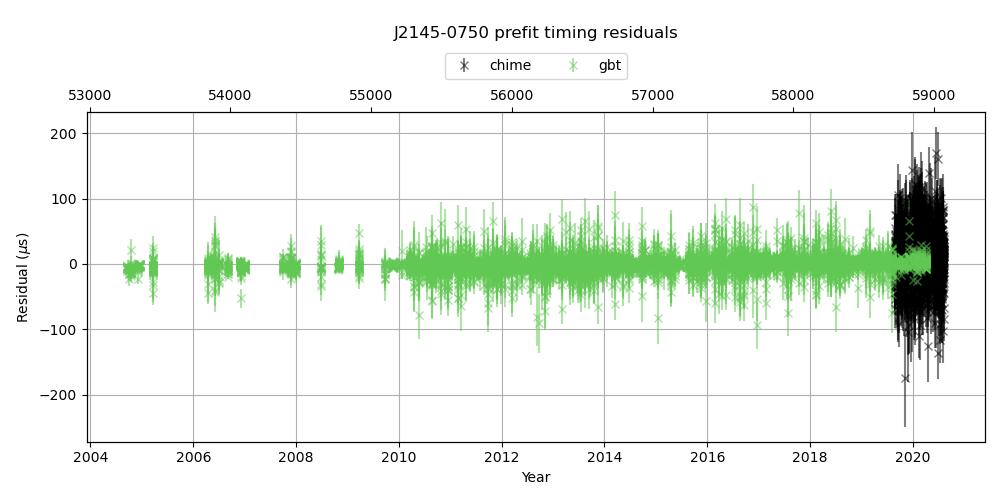

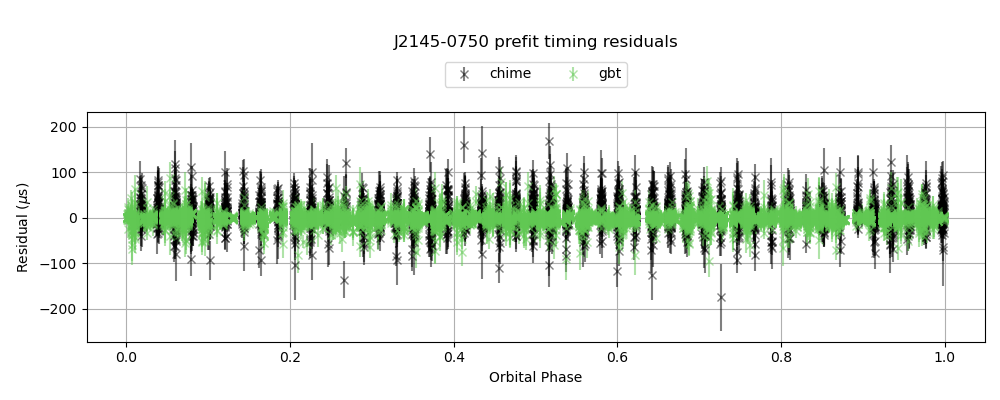

In [9]:
# Define the fitter object and plot pre-fit residuals
fo = tc.construct_fitter(to,mo)
pu.plot_residuals_time(fo, colorby='obs', restype='prefit')
if mo.is_binary:
    pu.plot_residuals_orb(fo, colorby='obs', restype='prefit')
if using_wideband:
    pu.plot_dm_residuals(fo, restype='prefit')

In [10]:
fo.print_summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


AttributeError: 'NoneType' object has no attribute 'value'

In [18]:
for pn in fo.model.params: 
    prefitpar = getattr(fo.model_init, pn) 
    if prefitpar is None: 
        print(f"{pn} is missing")

### Check that free-params follow NANOGrav conventions, fit
fo.model.free_params = tc.get_free_params(fo)
lu.check_fit(fo,skip_check=tc.skip_check)

try:
    fo.fit_toas(maxiter=tc.get_niter())
    fo.model.CHI2.value = fo.resids.chi2
except ConvergenceFailure:
    run_Ftest = False
    log.warning('Failed to converge; moving on with best result, but should address before final version.')

In [ ]:
# plot dmx over time and residuals 
pu.plot_dmx_time(fo)
pu.plot_residuals_time(fo)

In [ ]:
# Plot post-fit residuals, print summary of results, write prenoise solution
pu.plot_residuals_time(fo, restype='postfit')
if mo.is_binary:
    pu.plot_residuals_orb(fo, restype='postfit')
if using_wideband:
    pu.plot_dm_residuals(fo, restype='postfit')
import numpy as np

np.save('newbin_' + str(chime_bin) + '_chi2_.npy', [chime_bin, float(fo.resids.reduced_chi2)])

print(fo.resids.reduced_chi2)

if not autorun: fo.print_summary()

lu.check_convergence(fo)

lu.write_par(fo,toatype=tc.get_toa_type(),addext='_prenoise_'+str(chime_bin),include_date=True)

In [ ]:
print(float(fo.resids.reduced_chi2))

In [ ]:
fo.print_summary()

In [37]:
print(fo.model.params)

['PSR', 'TRACK', 'EPHEM', 'CLOCK', 'UNITS', 'START', 'FINISH', 'RM', 'INFO', 'TIMEEPH', 'T2CMETHOD', 'BINARY', 'DILATEFREQ', 'DMDATA', 'NTOA', 'CHI2', 'CHI2R', 'TRES', 'DMRES', 'POSEPOCH', 'PX', 'ELONG', 'ELAT', 'PMELONG', 'PMELAT', 'ECL', 'F0', 'PEPOCH', 'F1', 'CORRECT_TROPOSPHERE', 'PLANET_SHAPIRO', 'NE_SW', 'SWP', 'SWM', 'DM', 'DM1', 'DMEPOCH', 'DMX', 'DMX_0001', 'DMXR1_0001', 'DMXR2_0001', 'DMX_0002', 'DMXR1_0002', 'DMXR2_0002', 'DMX_0003', 'DMXR1_0003', 'DMXR2_0003', 'DMX_0004', 'DMXR1_0004', 'DMXR2_0004', 'DMX_0005', 'DMXR1_0005', 'DMXR2_0005', 'DMX_0006', 'DMXR1_0006', 'DMXR2_0006', 'DMX_0007', 'DMXR1_0007', 'DMXR2_0007', 'DMX_0008', 'DMXR1_0008', 'DMXR2_0008', 'DMX_0009', 'DMXR1_0009', 'DMXR2_0009', 'DMX_0010', 'DMXR1_0010', 'DMXR2_0010', 'DMX_0011', 'DMXR1_0011', 'DMXR2_0011', 'DMX_0012', 'DMXR1_0012', 'DMXR2_0012', 'DMX_0013', 'DMXR1_0013', 'DMXR2_0013', 'DMX_0014', 'DMXR1_0014', 'DMXR2_0014', 'DMX_0015', 'DMXR1_0015', 'DMXR2_0015', 'DMX_0016', 'DMXR1_0016', 'DMXR2_0016', 'DM

In [ ]:
x = to.table['obs'] == 'chime'
q = to.table[x]['mjd']

y = x==0
z = to.table[y]['mjd']

print(np.argmin(z))
print(np.min(z))
print(np.max(z))
print(np.min(q))
print(np.max(q))

In [ ]:
from pint.toa import get_TOAs
#t = get_TOAs(pint.config.examplefile("B1855+09_NANOGrav_dfg+12.tim"), model=mo)
t = get_TOAs("J2145-0750_PINT_20240213.nb.tim", model=mo)
print(t['mjd'])


In [ ]:
print(np.array(t['mjd']))
#print(t['mjd'] > 0.)

In [ ]:
mjd_values = [time.value for time in t['mjd']]
h = np.array(mjd_values) > 0.
print(np.size(h))

In [ ]:
print(np.size(to.table['obs']))
print(mo.NTOA)

So the model does have the same number of TOAs as the dataset, it's just a matter of matching them...

In [ ]:
mo.START = 53267.183254166666
print(mo.START)

# \[noise\] analysis, re-fit

Noise analysis runs are required for the 15-yr v1.0 data set, using the latest available timing model and set of TOAs. If TOA excision or free parameters are changed in the `.yaml`/`.par` file(s), new noise model parameters should be generated before proceeding. Use the [prenoise] section of this notebook to improve TOA excision, ensure residuals are flat, then submit a merge request with that solution, and wait for noise results to be made available. See the "Automatic Runs on Thorny Flats" wiki to request new runs, or make a note for your pulsar(s) in the who-which page.

We strongly discourage running noise analyses from on the notebook server, since doing so can take several hours (or days!) to complete and hogs lots of shared resources. Set `run_noise_analysis = False` unless you have a good reason to do otherwise.

In [ ]:
noise_dir = None   # fill in directory name here if appropriate
compare_noise_dir = None   # fill in directory name here if appropriate
fo_noise = fo      # fallback in case the noise model can't be found
if noise_dir is not None:
    tc.config['intermediate-results']['noise-dir'] = noise_dir
if compare_noise_dir is not None:
    tc.config['intermediate-results']['compare-noise-dir'] = compare_noise_dir
print(f"Looking for noise chains in {tc.get_noise_dir()}")

In [ ]:
if not autorun: check_recentness_noise(tc);

If `run_noise_analysis = True`, perform noise modeling using enterprise and enterprise_extensions; this cell will take a long time to run. Status can be monitored once modeling is 1% complete. New noise parameters will be added to the timing model if there are existing results or `model_noise` is run. Redefine the fitter object (`fo`), now with noise parameters, and re-fit.

In [ ]:
if run_noise_analysis or use_existing_noise_dir:
    mo_new = copy.deepcopy(mo)
    lu.remove_noise(mo_new)
    nu.model_noise(mo_new, to, using_wideband = using_wideband, run_noise_analysis = run_noise_analysis, n_iter = num_noise_iter)
    try:
        mo_new = nu.add_noise_to_model(mo_new, using_wideband = using_wideband, base_dir=tc.get_noise_dir(), 
                                       compare_dir=tc.get_compare_noise_dir(), no_corner_plot=tc.get_no_corner())
        
    except OSError as e:
        log.warning(f"Unable to read noise chains from {tc.get_noise_dir()}: {e}")
    else:
        mo = mo_new
        fo_noise = tc.construct_fitter(to,mo)
        fo_noise.model.free_params = tc.get_free_params(fo_noise)
        
        try:
            fo_noise.fit_toas(maxiter=tc.get_niter())
            fo_noise.model.CHI2.value = fo_noise.resids.chi2
        except ConvergenceFailure:
            run_Ftest = False
            log.warning('Failed to converge; moving on with best result, but should address before final version.')
        
        pu.plot_residuals_time(fo_noise, restype='postfit')
        if mo.is_binary:
            pu.plot_residuals_orb(fo_noise, restype='postfit')
        if not autorun: fo_noise.print_summary()

In [ ]:
# write par, tim, dmx files
outpar = None  # None leads to default string value
lu.write_par(fo_noise,toatype=tc.get_toa_type(),outfile=outpar,include_date=True)

to.table = to.orig_table # resurrect cut TOAs to write, commented
fo_cuts = tc.construct_fitter(to,mo)
outtim = None  # None leads to default string value
lu.write_tim(fo_cuts,toatype=tc.get_toa_type(),outfile=outtim,commentflag='cut')
apply_cut_select(to,reason='resumption after write_tim') # de-select cut TOAs once again

dmx_dict = dmxparse(fo_noise, save="dmxparse.out")  # requires DMX bins in model to run properly

# check [excision] results

Check the percentage of good TOAs compared to automatically and manually excised TOAs. An excision "donut" plot will be included in the notebook as well as a warning if lots of TOAs have been excised.

In [ ]:
cuts_dict = None
if check_excision:
    cuts_dict = lu.cut_summary(to, tc, print_summary=True, save=True)
    lu.plot_cuts_all_backends(to, save=True, using_wideband=using_wideband, source_name=tc.get_source())
    lu.highlight_cut_resids(to, mo, tc, ylim_good=True, save=True)

# \[compare\] to previous timing model

Compare post-fit model to `compare-model` (or pre-fit model, if `compare-model` is not specified in the `.yaml` file). Use `?mo.compare` for more information about verbosity options.

In [ ]:
lu.compare_models(fo_noise,
               model_to_compare=tc.get_compare_model(),
               verbosity='check',
               nodmx=True,
               threshold_sigma=3.)

# check parameter \[significance\]

Get information on the weighted (W)RMS residuals per backend. Set `epoch_avg = True` to get the (W)RMS of the epoch-averaged residuals (does not work for wideband analysis; the timing model must have `ECORR` in order for epoch averaging to work). Set `whitened = True` to get the (W)RMS of the whitened residuals. Set both to `True` to get the (W)RMS of the whitened, epoch-averaged residuals.

For wideband analysis, set `dm_stats = True` to also return the (W)RMS of the DM residuals.

In [ ]:
dm_dict = None
epoch_avg = 'ecorr_noise' in fo_noise.model.get_components_by_category()
if not using_wideband:
    rs_dict = resid_stats(fo_noise, 
                          epoch_avg=epoch_avg,
                          whitened=True, 
                          print_pretty=True)
else:
    rs_dict, dm_dict = resid_stats(fo_noise, 
                                   whitened=True, 
                                   dm_stats=True, 
                                   print_pretty=True)

Run F-tests to check significance of existing/new parameters; `alpha` is the p-value threshold for rejecting the null hypothesis that a parameter is not significant. This cell may take 5-10 minutes to run. 

In [ ]:
Ftest_dict = None
if run_Ftest:
    savedLevel = log.getEffectiveLevel()
    try:
        log.setLevel("WARNING")
        Ftest_dict = run_Ftests(fo_noise, 
                                alpha=0.0027, 
                                NITS=tc.get_niter())
    finally:
        log.setLevel(savedLevel)

# generate \[summary\] pdf

Generate summary plots required for pdf summaries. Note: this cell will output white space for the plots, but will save them and incorporate them into the pdf summaries appropriately.

In [ ]:
if not using_wideband:
    pu.plots_for_summary_pdf_nb(fo_noise)
else:
    pu.plots_for_summary_pdf_wb(fo_noise)

In [ ]:
PARFILE = os.path.join(tc.par_directory,tc.config["timing-model"])
pdf_writer(fo, PARFILE, rs_dict, 
           Ftest_dict=Ftest_dict, 
           dm_dict=dm_dict, 
           previous_parfile=tc.get_compare_model(), 
           fitter_noise=fo_noise,
           cuts_dict=cuts_dict,
           no_corner=tc.get_no_corner())

# \[changelog\] entries

New changelog entries in the `.yaml` file should follow a specific format and are only added for specified reasons (excising TOAs, adding/removing params, changing binary models, etc.). For more detailed instructions, run `lu.new_changelog_entry?` in a new cell. This function can be used to format your entry, which should be added to the bottom of the appropriate `.yaml` file. Note: make sure your git `user.email` is properly configured, since this field is used to add your name to the entry.